In [1]:
import os
import nest_asyncio
from dotenv import load_dotenv
from typing import Optional

# --- Importaciones LlamaIndex ---
from llama_index.core import Settings, VectorStoreIndex, StorageContext, Document
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_parse import LlamaParse
#from llama_index.readers.file import PyMuPDFReade

# --- Importaciones Qdrant ---
from qdrant_client import QdrantClient

# --- Importaciones LangChain (Inteligencia de Extracción) ---
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field

/home/david/uc_chile/proyecto_aplicado_1/rag/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. CARGA DE ENTORNO Y VALIDACIÓN (TU CÓDIGO)
# ==========================================================
nest_asyncio.apply()
load_dotenv()

# Configuración OpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("❌ No se encontró OPENAI_API_KEY en el .env")

# Configuración Qdrant
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = "metabolomics_agent_db" # Tu colección definida

if not QDRANT_URL:
    raise ValueError("❌ No se encontró QDRANT_URL en el .env")
if not QDRANT_API_KEY:
    raise ValueError("❌ No se encontró QDRANT_API_KEY en el .env")

# Configuración LlamaCloud
LLAMA_CLOUD_API_KEY = os.getenv("LLAMA_CLOUD_API_KEY")
if not LLAMA_CLOUD_API_KEY:
    raise ValueError("❌ No se encontró LLAMA_CLOUD_API_KEY en el .env")

print("✅ Credenciales validadas correctamente.")

✅ Credenciales validadas correctamente.


In [3]:
# 2. INICIALIZACIÓN DE CLIENTES Y MODELOS
# ==========================================================

# A. Cliente Qdrant (Conectado a tu Cloud)
qdrant_client = QdrantClient(
    url=QDRANT_URL, 
    api_key=QDRANT_API_KEY,
)

# Verificar conexión imprimiendo colecciones (opcional)
print(qdrant_client.get_collections())

# B. LlamaIndex Embeddings (Para Vectores Densos)
# Usará automáticamente la OPENAI_API_KEY del entorno
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

# C. LangChain LLM (Para Extracción y CDE)
# Usando init_chat_model como pediste
llm_chat = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    temperature=0
)

collections=[]


In [4]:
# 3. SCHEMA DE DATOS (PYDANTIC)
# ==========================================================
class MetaboliteMetadata(BaseModel):
    """
    Modelo para la extracción estructurada de features metabolómicas.
    """
    mz_value: Optional[float] = Field(default=None, description="La relación masa/carga (m/z) exacta.")
    rt_value: Optional[float] = Field(default=None, description="El tiempo de retención (RT) en minutos.")
    compound_name: Optional[str] = Field(default=None, description="Nombre del compuesto químico identificado o putativo.")
    sample_source: Optional[str] = Field(default=None, description="Matriz biológica o fuente de la muestra (ej. Té Verde).")

# Vinculamos el LLM con el Schema
metadata_extractor = llm_chat.with_structured_output(MetaboliteMetadata)

In [5]:
# Imports necesarios
from sentence_transformers import SentenceTransformer
from langchain_qdrant import FastEmbedSparse, RetrievalMode, QdrantVectorStore
import random
import torch
import os

# --- Modelo CDE (SentenceTransformers)
cde_model = SentenceTransformer("jxm/cde-small-v2", trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# sentence-transformers devuelve tensores si convert_to_tensor=True; movemos a cpu/gpu según convenga.
cde_model.to(device)

# --- Modelo sparse (BM25)
sparse_model = FastEmbedSparse(model_name="Qdrant/bm25")

# Helper: generar dataset_embeddings (Stage 1)
def build_dataset_embeddings_from_text(full_text: str, num_samples: int = None):
    """
    Divide full_text en párrafos y toma una muestra representativa para generar
    los dataset embeddings (CDE Stage 1). Devuelve un tensor (convert_to_tensor=True).
    """
    paras = [p.strip() for p in full_text.split("\n") if len(p.strip()) > 50]
    if not paras:
        # fallback: usar el full_text como único "paragraph"
        paras = [full_text[:4000]]

    # cantidad a muestrear (por defecto el modelo recomienda ~512)
    default_size = getattr(cde_model[0].config, "transductive_corpus_size", 512)
    k = min(num_samples or default_size, len(paras))

    # si hay menos párrafos que k, usa todos
    if len(paras) <= k:
        minicorpus = paras
    else:
        minicorpus = random.sample(paras, k)

    # Prepend prefix obligatorio (según ejemplo del autor)
    document_prefix = "search_document: "
    minicorpus_prefixed = [document_prefix + p for p in minicorpus]

    # Encode en batch (convert_to_tensor=True)
    dataset_embeddings = cde_model.encode(
        minicorpus_prefixed,
        prompt_name="document",
        convert_to_tensor=True,
        show_progress_bar=False
    )

    # Mover a device (si no lo está)
    if isinstance(dataset_embeddings, torch.Tensor):
        dataset_embeddings = dataset_embeddings.to(device)

    return dataset_embeddings

# Helper: encode de Stage 2 (por chunk)
def cde_encode_chunk(text: str, dataset_embeddings):
    """
    Re-embed un texto (chunk) usando dataset_embeddings (Stage 2).
    Devuelve un array numpy 1-D (normalizado).
    """
    document_prefix = "search_document: "
    text_prefixed = document_prefix + text

    # SentenceTransformer encode con dataset_embeddings como en el ejemplo
    emb = cde_model.encode(
        [text_prefixed],
        prompt_name="document",
        dataset_embeddings=dataset_embeddings,
        convert_to_tensor=True,
        show_progress_bar=False
    )

    # emb es un tensor shape (1, D). Normalizamos por seguridad y devolvemos numpy
    if isinstance(emb, torch.Tensor):
        emb = emb.to(device)
        emb = emb / torch.linalg.norm(emb, dim=-1, keepdim=True)
        return emb[0].cpu().numpy()
    else:
        # si no es tensor (caso raro), convertir y normalizar con numpy
        import numpy as np
        emb = np.array(emb)
        emb = emb / (np.linalg.norm(emb, axis=-1, keepdims=True) + 1e-12)
        return emb[0]

# -------------------------------------------------------
# Función principal (mantiene tu estructura)
# -------------------------------------------------------
async def procesar_pdf_completo(file_path):
    print(f"\n📄 [1/5] Parseando PDF: {file_path}")
    
    # A. LlamaParse: PDF -> Markdown
    parser = LlamaParse(result_type="markdown", language="en")
    documents = await parser.aload_data(file_path)
    full_text = documents[0].text

    # B. CDE Stage 1: generar dataset_embeddings (una vez por documento)
    print("🧠 [2/5] Generando dataset_embeddings (CDE Stage 1)...")
    dataset_embeddings = build_dataset_embeddings_from_text(full_text)
    print(f"     → Dataset embeddings generados: {dataset_embeddings.shape if isinstance(dataset_embeddings, torch.Tensor) else 'OK'}")

    # C. Semantic Chunking (mantén tu splitter)
    print("✂️ [3/5] Generando chunks semánticos...")
    splitter = SemanticSplitterNodeParser(
        buffer_size=1, 
        breakpoint_percentile_threshold=95, 
        embed_model=Settings.embed_model  # tu splitter original
    )
    nodes = splitter.get_nodes_from_documents(documents)
    print(f"     → Chunks generados: {len(nodes)}")

    # D. Enriquecimiento (Dense CDE Stage 2 + Sparse BM25 + extracción)
    print("🔬 [4/5] Enriqueciendo chunks con embeddings (dense + sparse) y extrayendo features...")
    nodes_enriquecidos = []

    for node in nodes:
        texto = node.get_content()

        # D.1 Dense embedding contextualizado (CDE Stage 2)
        try:
            dense_vec = cde_encode_chunk(texto, dataset_embeddings)  # numpy 1-D
            node.metadata["dense_embedding"] = dense_vec.tolist()
        except Exception as e:
            # si falla, continuar y dejar sin dense (pero avisar)
            print("WARN: Falló CDE Stage2 para un chunk:", str(e))
            node.metadata["dense_embedding"] = None

        # D.2 Sparse embedding (BM25)
        try:
            # fastembed.sparse.FastEmbedSparse.embed_query(text) -> lista o array; adaptamos a lista
            sparse_vec = sparse_model.embed_query(texto)
            # Normalizamos la forma: si devuelve lista de vectores, tomar el primero
            if isinstance(sparse_vec, (list, tuple)) and len(sparse_vec) > 0:
                sparse_vec = sparse_vec[0]
            node.metadata["sparse_embedding"] = sparse_vec
        except Exception as e:
            print("WARN: Falló cálculo sparse:", str(e))
            node.metadata["sparse_embedding"] = None

        # D.3 metadata de archivo
        node.metadata["file_name"] = os.path.basename(file_path)

        # D.4 Extracción estructurada (m/z, RT, etc.)
        try:
            data = metadata_extractor.invoke(texto)
            if getattr(data, "mz_value", None) is not None:
                print(f"      ✅ Feature: m/z {data.mz_value} ({data.compound_name})")
                node.metadata.update(data.model_dump(exclude_none=True))
        except Exception:
            # no interrumpir pipeline por errores en extractor
            pass

        nodes_enriquecidos.append(node)

    print("🎉 [5/5] PDF procesado: retornando chunks enriquecidos.")
    return nodes_enriquecidos


`torch_dtype` is deprecated! Use `dtype` instead!


Disabled 23 dropout modules from model type <class 'transformers_modules.jxm.cde_hyphen_small_hyphen_v2.4e1d021a6c3fd7ce8aa0a7204057eee5ae61d390.model.BiEncoder'>
Disabled 46 dropout modules from model type <class 'transformers_modules.jxm.cde_hyphen_small_hyphen_v2.4e1d021a6c3fd7ce8aa0a7204057eee5ae61d390.model.ContextualDocumentEmbeddingTransformer'>


In [16]:
from qdrant_client.http import models as qmodels

# Crear colección si no existe
def ensure_collection():
    collections = qdrant_client.get_collections().collections
    names = [c.name for c in collections]

    if COLLECTION_NAME not in names:
        print(f"🟡 Creando colección '{COLLECTION_NAME}' en Qdrant...")

        qdrant_client.create_collection(
            collection_name=COLLECTION_NAME,
            vectors_config=qmodels.VectorParams(
                size=1536,                # dimensión text-embedding-3-small
                distance=qmodels.Distance.COSINE
            )
        )

        print("✅ Colección creada.")
    else:
        print(f"🟢 La colección '{COLLECTION_NAME}' ya existe.")

ensure_collection()


🟢 La colección 'metabolomics_agent_db' ya existe.


In [18]:
import glob
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_core.documents import Document

# Embeddings de LangChain (correcto para evitar el error)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# ==========================================================
# 5. EJECUCIÓN PRINCIPAL (CON RUTA RELATIVA CORREGIDA)
# ==========================================================

async def main_ingest():
    ruta_data = os.path.join("..", "data", "*.pdf")
    pdf_files = glob.glob(ruta_data)
    
    print(f"📂 Buscando archivos en: {ruta_data}")
    
    if not pdf_files:
        print("❌ No se encontraron PDFs en la carpeta '../data'.")
        print(f"   Directorio actual: {os.getcwd()}")
        return None

    print(f"✅ Se encontraron {len(pdf_files)} archivos PDF: {[os.path.basename(f) for f in pdf_files]}")

    # 2. VectorStore usando tu cliente YA INICIALIZADO (correcto con LangChain)
    vector_store = QdrantVectorStore(
        client=qdrant_client,
        collection_name=COLLECTION_NAME,
        embedding=embeddings
    )

    all_docs = []
    
    # 3. Procesamiento de Archivos encontrados
    for pdf in pdf_files:
        try:
            # LlamaIndex → devuelve TextNodes
            nodos = await procesar_pdf_completo(pdf)

            # Convertir a langchain.schema.Document
            docs = [
                Document(
                    page_content=n.text,
                    metadata=n.metadata
                )
                for n in nodos
            ]

            all_docs.extend(docs)

        except Exception as e:
            print(f"⚠️ Error procesando {os.path.basename(pdf)}: {e}")

    # 4. Ingesta FINAL en Qdrant
    print("\n🚀 Subiendo vectores a Qdrant Cloud...")
    vector_store.add_documents(all_docs)
    print(f"✅ ¡Ingesta completada! {len(all_docs)} fragmentos subidos.")

    return vector_store

# --- EJECUTAR ---
index = await main_ingest()



📂 Buscando archivos en: ../data/*.pdf
✅ Se encontraron 1 archivos PDF: ['1-s2.0-S0022316622152399-main.pdf']

📄 [1/5] Parseando PDF: ../data/1-s2.0-S0022316622152399-main.pdf
Started parsing the file under job_id 537bf1bd-6f19-4507-98cb-aef81bf1a0f3
🧠 [2/5] Generando dataset_embeddings (CDE Stage 1)...
     → Dataset embeddings generados: torch.Size([6, 768])
✂️ [3/5] Generando chunks semánticos...
     → Chunks generados: 33
🔬 [4/5] Enriqueciendo chunks con embeddings (dense + sparse) y extrayendo features...
      ✅ Feature: m/z 287.1 (Cyanidin-3-glucoside)
      ✅ Feature: m/z 250.123 (Caffeine)
      ✅ Feature: m/z 1865.0 (None)
      ✅ Feature: m/z 0.0 (3-O-β-glucoside of pelargonidin)
      ✅ Feature: m/z 250.123 (Caffeine)
      ✅ Feature: m/z 449.1 (Cyanidin-3-O-β-glucoside)
      ✅ Feature: m/z 581.0 (Cyanidin-3-glucoside)
      ✅ Feature: m/z 0.0 (Peonidin mono-glucuronide)
      ✅ Feature: m/z 625.3 (None)
      ✅ Feature: m/z 287.2 (Cyanidin-3-glucoside monoglucuronide)
   

## Simulación del retrieval

In [ ]:
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.vector_stores import MetadataFilters, MetadataFilter, FilterOperator
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.openai import OpenAIEmbedding

# 1. Cargar Credenciales
load_dotenv()

# Configurar el modelo de embedding (debe ser el mismo que usaste en la ingesta)
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

# 2. Conectar a tu Base de Datos Existente
client = QdrantClient(
    url=os.getenv("QDRANT_URL"),
    api_key=os.getenv("QDRANT_API_KEY"),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="metabolomics_agent_db", # <--- La misma colección que creaste
    enable_hybrid=True # <--- Importante para buscar por texto + semántica
)

# Reconstruimos el índice desde Qdrant (no lo crea de nuevo, solo se conecta)
index = VectorStoreIndex.from_vector_store(vector_store=vector_store)

# ==========================================
# 3. SIMULACIÓN DE CONSULTA DEL PROYECTO
# ==========================================

# 🔹 ESCENARIO: El usuario busca m/z 449.1
# En tu log vimos que detectó "Cyanidin-3-O-β-glucoside" con m/z 449.1
MZ_TARGET = 449.1 
TOLERANCIA = 0.5 # +/- 0.5 Da de margen de error

print(f"🔎 Buscando features con m/z entre {MZ_TARGET - TOLERANCIA} y {MZ_TARGET + TOLERANCIA}...")

# A. Definir Filtros (Solo traer documentos con ese rango de masa)
filters = MetadataFilters(
    filters=[
        MetadataFilter(
            key="mz_value", 
            operator=FilterOperator.GTE, 
            value=MZ_TARGET - TOLERANCIA
        ),
        MetadataFilter(
            key="mz_value", 
            operator=FilterOperator.LTE, 
            value=MZ_TARGET + TOLERANCIA
        ),
    ]
)

# B. Configurar el Motor de Recuperación (Retriever)
retriever = index.as_retriever(
    filters=filters,      # Aplicar filtro numérico primero
    similarity_top_k=3,   # Traer los 3 mejores chunks
    vector_store_kwargs={"qdrant_client": client}
)

# C. Ejecutar la Pregunta
# Preguntamos por "bioactividad" para usar la búsqueda híbrida (Semántica)
results = retriever.retrieve("¿Qué compuesto es y qué bioactividad tiene?")

# 4. Mostrar Resultados
if not results:
    print("❌ No se encontraron coincidencias.")
else:
    print(f"✅ Se encontraron {len(results)} documentos relevantes:\n")
    for i, res in enumerate(results):
        meta = res.metadata
        print(f"--- Resultado {i+1} ---")
        print(f"📄 Archivo: {meta.get('file_name')}")
        print(f"🧪 Feature Detectada: m/z {meta.get('mz_value')} | Nombre: {meta.get('compound_name')}")
        print(f"📝 Fragmento del texto:\n\"{res.get_content()[:200]}...\"\n")

In [ ]:
from langchain.messages import SystemMessage, HumanMessage

# ==========================================
# PASO 3: GENERACIÓN DE RESPUESTA (LLM)
# ==========================================

def generar_reporte_final(query_usuario, resultados_recuperados, llm):
    """
    Toma la pregunta del usuario y los chunks recuperados de Qdrant
    para generar una respuesta científica sintetizada.
    """
    
    # 1. Preparar el Contexto (Unir los fragmentos recuperados)
    contexto_texto = ""
    for i, res in enumerate(resultados_recuperados):
        meta = res.metadata
        contexto_texto += f"""
        [Documento {i+1}]
        - Fuente: {meta.get('file_name')}
        - Compuesto Detectado: {meta.get('compound_name')} (m/z {meta.get('mz_value')})
        - Fragmento: "{res.get_content()}"
        -------------------------------------------
        """

    # 2. Crear el Prompt para el Experto
    prompt_sistema = """
    Eres un asistente experto en Metabolómica y Química Analítica.
    Tu tarea es responder a la consulta del investigador basándote EXCLUSIVAMENTE en el contexto proporcionado.
    
    Reglas:
    1. Identifica el compuesto putativo basándote en el m/z y RT si están disponibles.
    2. Resume las bioactividades mencionadas en el texto recuperado.
    3. Cita la fuente (Documento X) para cada afirmación.
    4. Si hay varios candidatos con el mismo m/z (isómeros), menciónalos y explica la diferencia si el texto lo dice.
    5. Sé conciso y profesional.
    """

    prompt_usuario = f"""
    Consulta del Investigador: "{query_usuario}"
    
    Contexto Recuperado de la Base de Datos Interna:
    {contexto_texto}
    
    Por favor, genera el informe de anotación funcional:
    """

    # 3. Invocar al LLM (Usando tu modelo llm_chat de LangChain ya configurado)
    mensajes = [
        SystemMessage(content=prompt_sistema),
        HumanMessage(content=prompt_usuario)
    ]
    
    print("🤖 Generando respuesta final...")
    respuesta = llm.invoke(mensajes)
    
    return respuesta.content

# --- EJECUCIÓN ---
# Usamos los 'results' que obtuviste en la celda anterior
query = "¿Qué compuesto es y qué bioactividad tiene?"
informe_final = generar_reporte_final(query, results, llm_chat)

print("\n" + "="*50)
print("📝 INFORME FINAL DEL AGENTE RAG")
print("="*50)
print(informe_final)

## Similaridad de chunks que tienen CDE

In [31]:
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
import numpy as np

collection = COLLECTION_NAME  # tu colección

# 1) Obtenemos TODOS los puntos subidos a Qdrant
points = qdrant_client.scroll(
    collection_name=collection,
    scroll_filter=None,
    with_payload=True,
    with_vectors=True,
    limit=2000
)[0]

print(f"🔢 Puntos recuperados de Qdrant: {len(points)}")

# 2) Ordenarlos por el campo "chunk_id" que tú subiste en payload
points_sorted = sorted(points, key=lambda x: x.payload.get("chunk_id", 0))

# 3) Extraer embeddings en orden
embeddings = [p.vector for p in points_sorted]

print("🔍 Shape embeddings:", np.array(embeddings).shape)


🔢 Puntos recuperados de Qdrant: 33
🔍 Shape embeddings: (33, 1536)


In [32]:
from numpy.linalg import norm

distances = []

for i in range(len(embeddings) - 1):
    v1 = np.array(embeddings[i])
    v2 = np.array(embeddings[i+1])

    cosine_sim = np.dot(v1, v2) / (norm(v1) * norm(v2))
    cosine_dist = 1 - cosine_sim

    distances.append(cosine_dist)

print("📏 Número de distancias:", len(distances))
print(distances[:5])


📏 Número de distancias: 32
[np.float64(0.7669773241015241), np.float64(0.7416514615783828), np.float64(0.6834199613642337), np.float64(0.5977623433210857), np.float64(0.8017203253262443)]


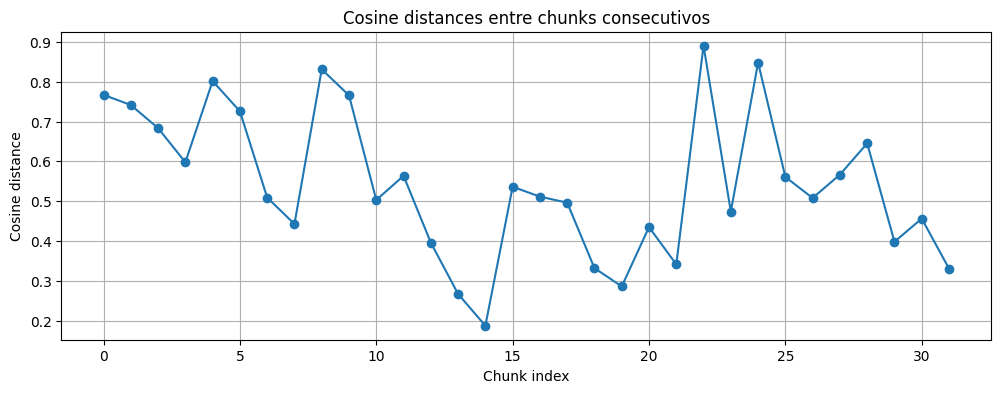

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(distances, marker='o')
plt.title("Cosine distances entre chunks consecutivos")
plt.xlabel("Chunk index")
plt.ylabel("Cosine distance")
plt.grid(True)
plt.show()
